In [3]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch._six import inf
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime

In [4]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 32
STEPS = 10
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D + K
NUM_OBS_LOCAL = D + K*D + K*D
BATCH_SIZE = 50
NUM_EPOCHS = 150
LEARNING_RATE = 1e-3
CUDA = False
PATH = 'ag-correct-50000datasets-oneshot-%dsteps' % STEPS

In [6]:
Xs = torch.from_numpy(np.load('../gmm_dataset_uai2/sequences.npy')).float()
# Zs_true = torch.from_numpy(np.load('gmm_dataset2/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset2/means.npy')).float()
# sigma_true = torch.from_numpy(np.load('gmm_dataset2/covariances.npy')).float()
Pi = torch.from_numpy(np.load('../gmm_dataset_uai2/init.npy')).float()
num_seqs = Xs.shape[0]

In [7]:
num_seqs

50000

In [8]:
class Encoder_init(nn.Module):
    def __init__(self, num_obs=D,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        q_alpha = torch.exp(self.sigmas_log_alpha(stats)).view(-1, K, D) ## B * K * D
        q_beta = torch.exp(self.sigmas_log_beta(stats)).view(-1, K, D) ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample((num_samples,)) ## S * B * K * D
        
        q_mean = self.mus_mean(stats).view(-1, K, D).unsqueeze(0).repeat(num_samples, 1, 1, 1)
        q_nu = torch.exp(self.mus_log_nu(stats).view(-1, K, D))
        q_sigma = torch.sqrt(1. / (q_nu.unsqueeze(0).repeat(num_samples, 1, 1, 1) * precisions))
        mus = Normal(q_mean, q_sigma).sample()  
        return q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions ## mus_mean and mus_sigma are S * B * K * D
    
class Encoder_global(nn.Module):
    def __init__(self, num_obs=NUM_OBS_GLOBAL,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))

        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        q_alpha = torch.exp(self.sigmas_log_alpha(stats)).view(-1, K, D) ## B * K * D
        q_beta = torch.exp(self.sigmas_log_beta(stats)).view(-1, K, D) ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample((num_samples,)) ## S * B * K * D
        
        q_mean = self.mus_mean(stats).view(-1, K, D).unsqueeze(0).repeat(num_samples, 1, 1, 1)
        q_nu = torch.exp(self.mus_log_nu(stats).view(-1, K, D))
        q_sigma = torch.sqrt(1. / (q_nu.unsqueeze(0).repeat(num_samples, 1, 1, 1) * precisions))
        mus = Normal(q_mean, q_sigma).sample()  
        return q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions ## mus_mean and mus_sigma are S * B * K * D
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
    def forward(self, obs, N, K, D, num_samples, batch_size):
        zs_pi = self.enc_onehot(obs).view(batch_size, N, K)
        zs = cat(zs_pi).sample((num_samples,))
        log_qz = cat(zs_pi).log_prob(zs).view(num_samples, batch_size, -1).sum(-1) ## S * B
        zs = zs.view(num_samples, batch_size, -1, K) ## S * B * N * K
        return zs_pi, zs, log_qz

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-1)     
        
def initialize():
    enc_init = Encoder_init()
    enc_global = Encoder_global()
    enc_local = Encoder_local()
    enc_global.apply(weights_init)
#     enc_init.apply(weights_init)
    optimizer =  torch.optim.Adam(list(enc_init.parameters()) + list(enc_global.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_init, enc_global, enc_local, optimizer
enc_init, enc_global, enc_local, optimizer = initialize()
# enc_init.load_state_dict(torch.load('models/global-enc-uai-oneshot-all'))

In [ ]:
PATH = 'ag-correct-stage2-50000datasets-oneshot-%dsteps' % STEPS
enc_init.load_state_dict(torch.load('models/global-enc-uai-oneshot-all'))

In [6]:
prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_nu = torch.ones((BATCH_SIZE, K, D)) * 0.3
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 3.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 3.0

def log_joints_gmm(X, Z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    log_probs = torch.zeros(batch_size).float()
    ## priors on mus and sigmas size B
    log_probs = log_probs + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    log_probs = log_probs + Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    sigmas = 1. / torch.sqrt(precisions)
    log_probs = log_probs + Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), 
                                   sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(X).sum(-1).sum(-1)
    return log_probs

def post_global(Xs, Zs, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size):
    stat1 = Zs.sum(1).unsqueeze(-1).repeat(1, 1, D) ## B * K * D
    xz_nk = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)) # B*N*K*D
    stat2 = xz_nk.sum(1) ## B*K*D
    stat3 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(Xs, Xs).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    stat1_nonzero = stat1
    stat1_nonzero[stat1_nonzero == 0.0] = 1.0
    x_bar = stat2 / stat1
    posterior_beta = prior_beta + (stat3 - (stat2 ** 2) / stat1_nonzero) / 2. + (stat1 * prior_nu / (stat1 + prior_nu)) * ((prior_nu**2) + x_bar**2 - 2 * x_bar *  prior_nu) / 2.
    posterior_nu = prior_nu + stat1
    posterior_mean = (prior_mean * prior_nu + stat2) / (prior_nu + stat1) 
    posterior_alpha = prior_alpha + (stat1 / 2.)
#     posterior_sigma = torch.sqrt(posterior_nu * (posterior_beta / posterior_alpha))
    return posterior_mean, posterior_nu, posterior_alpha, posterior_beta

def post_local(Xs, Pi, mus, precisions, N, K, D, batch_size):
    sigma = 1. / torch.sqrt(precisions)
    mus_expand = mus.unsqueeze(2).repeat(1, 1, N, 1)
    sigma_expand = sigma.unsqueeze(2).repeat(1, 1, N, 1)
    Xs_expand = Xs.unsqueeze(1).repeat(1, K, 1, 1)
    log_gammas = Normal(mus_expand, sigma_expand).log_prob(Xs_expand).sum(-1).transpose(-1, -2) # B * N * K
    log_pis = log_gammas - logsumexp(log_gammas, dim=-1).unsqueeze(-1)
    return log_pis

# def inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
#     precisions = Gamma(prior_alpha, prior_beta).sample()
#     prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
#     mus = Normal(prior_mean, prior_sigma).sample()
#     ## log prior size B
#     log_p =  Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1) + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
#     return mus, precisions, log_p
def Init_step(X, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    data = X.view(batch_size*N, -1)
    
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc_init(data, K, D, 1, batch_size) 
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    log_q_eta =  Normal(q_mean[0], q_sigma[0]).log_prob(mus[0]).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions[0]).sum(-1).sum(-1)## B
    log_p_eta = Normal(prior_mean, prior_sigma).log_prob(mus[0]).sum(-1).sum(-1) + Gamma(prior_alpha, prior_beta).log_prob(precisions[0]).sum(-1).sum(-1)## B
    return q_mean[0], q_nu, q_alpha, q_beta, q_sigma[0], mus[0], precisions[0], log_q_eta, log_p_eta

def E_step(X, mus, precisions, N, D, K, batch_size):
    mus_flat = mus.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    sigma = 1. / torch.sqrt(precisions)
    sigma_flat = sigma.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    data = torch.cat((X, mus_flat, sigma_flat), -1).view(batch_size*N, -1)
    zs_pi, zs, log_q_z = enc_local(data, N, K, D, 1, batch_size)
    return zs_pi, zs[0], log_q_z[0]

def M_step(X, z, N, D, K, batch_size):
    data = torch.cat((X, z), dim=-1).view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc_global(data, K, D, 1, batch_size)  
    log_q_eta =  Normal(q_mean[0], q_sigma[0]).log_prob(mus[0]).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions[0]).sum(-1).sum(-1)## B
    return q_mean[0], q_nu, q_alpha, q_beta, q_sigma[0], mus[0], precisions[0], log_q_eta

def kls_step(x, z, q_mean, q_nu, q_alpha, q_beta, zs_pi, mus, precisions, N, K, D, batch_size):
    p_mean, p_nu, p_alpha, p_beta = post_global(x, z, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size)
    kl_eta_ex, kl_eta_in = kls_NGs(p_mean, p_nu, p_alpha, p_beta, q_mean, q_nu, q_alpha, q_beta)
    p_logits = post_local(x, Pi, mus, precisions, N, K, D, batch_size)
    kl_z_ex, kl_z_in = kls_cats(p_logits, torch.log(zs_pi))
    return kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in

def ag(x, Pi, N, K, D, num_samples, steps, batch_size):
    """
    train both encoders
    rws gradient estimator
    sis sampling scheme
    no resampling
    """
    kls_eta_ex_os = torch.zeros((num_samples, batch_size))
    kls_eta_in_os = torch.zeros((num_samples, batch_size))
    kls_z_ex_os = torch.zeros((num_samples, batch_size))
    kls_z_in_os = torch.zeros((num_samples, batch_size))
    
    kls_eta_ex_ag = torch.zeros((num_samples, batch_size))
    kls_eta_in_ag = torch.zeros((num_samples, batch_size))
    kls_z_ex_ag = torch.zeros((num_samples, batch_size))
    kls_z_in_ag = torch.zeros((num_samples, batch_size))
    ##
    log_increment_weights = torch.zeros((steps, num_samples, batch_size))
    Z_samples = torch.zeros((num_samples, batch_size, N, K))
    for m in range(steps):
        if m == 0:
            for l in range(num_samples):
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta, log_p_eta = Init_step(x, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                labels = z.nonzero()
                log_p_z = cat(Pi).log_prob(z).sum(-1)
                sigmas = 1. / torch.sqrt(precisions)
                log_p_x = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1)
                log_increment_weights[m, l] = log_p_x + log_p_z + log_p_eta - log_q_z - log_q_eta
                kl_eta_ex_os, kl_eta_in_os, kl_z_ex_os, kl_z_in_os = kls_step(x, z, q_mean, q_nu, q_alpha, q_beta, zs_pi, mus, precisions, N, K, D, batch_size)
                kls_eta_ex_os[l] = kl_eta_ex_os
                kls_eta_in_os[l] = kl_eta_in_os
                kls_z_ex_os[l] = kl_z_ex_os
                kls_z_in_os[l] = kl_z_in_os
        else:
            for l in range(num_samples):
                z_prev = Z_samples[l]
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z_prev, N, D, K, batch_size)
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                log_p_joint = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_q_z - log_q_eta
                if m == (steps-1):
                    kl_eta_ex_ag, kl_eta_in_ag, kl_z_ex_ag, kl_z_in_ag = kls_step(x, z, q_mean, q_nu, q_alpha, q_beta, zs_pi, mus, precisions, N, K, D, batch_size)
                    kls_eta_ex_ag[l] = kl_eta_ex_ag
                    kls_eta_in_ag[l] = kl_eta_in_ag
                    kls_z_ex_ag[l] = kl_z_ex_ag
                    kls_z_in_ag[l] = kl_z_in_ag
                    
    increment_weights = torch.exp(log_increment_weights - logsumexp(log_increment_weights, 1).unsqueeze(1).repeat(1, num_samples, 1)).detach()
    ess = (1./ (increment_weights ** 2).sum(1)).mean(0).mean()   
#     ess = (1./ (increment_weights ** 2).sum(1)).mean(0).mean() 
    ## EUBO and ELBO
    eubos = torch.mul(increment_weights, log_increment_weights).sum(1)
    eubo = eubos.mean(0).mean()
    
    elbos = log_increment_weights.mean(1)
    elbo = elbos.mean(0).mean()
    ## eubo and elbo at init step
    eubo_os = eubos[0].mean()
    elbo_os = elbos[0].mean()
    ## eubo and elbo at init step
    eubo_ag = eubos[-1].mean()
    elbo_ag = elbos[-1].mean()
    ## KL at init steps
    oneshot_weights = increment_weights[0]
    KL_eta_ex_os = torch.mul(oneshot_weights, kls_eta_ex_os).sum(0).mean()
    KL_eta_in_os = torch.mul(oneshot_weights, kls_eta_in_os).sum(0).mean()
    KL_z_ex_os = torch.mul(oneshot_weights, kls_z_ex_os).sum(0).mean()
    KL_z_in_os = torch.mul(oneshot_weights, kls_z_in_os).sum(0).mean()       
    ## KL after 10 steps
    final_weights = increment_weights[-1]
    KL_eta_ex_ag = torch.mul(final_weights, kls_eta_ex_ag).sum(0).mean()
    KL_eta_in_ag = torch.mul(final_weights, kls_eta_in_ag).sum(0).mean()
    KL_z_ex_ag = torch.mul(final_weights, kls_z_ex_ag).sum(0).mean()
    KL_z_in_ag = torch.mul(final_weights, kls_z_in_ag).sum(0).mean()  
    
    return eubo, elbo, ess, eubo_os, elbo_os, eubo_ag, elbo_ag, KL_eta_ex_os, KL_eta_in_os, KL_z_ex_os, KL_z_in_os, KL_eta_ex_ag, KL_eta_in_ag, KL_z_ex_ag, KL_z_in_ag

def shuffler(batch_Xs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    return torch.gather(batch_Xs, 1, indices_Xs)

In [7]:
flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO_ave, ELBO_ave, ESS, EUBO_os, ELBO_os, EUBO_ag, ELBO_ag, KLs_eta_ex_os, KLs_eta_in_os, KL_z_ex_os, KL_z_in_os, KLs_eta_ex_ag, KLs_eta_in_ag, KL_z_ex_ag, KL_z_in_ag\n')
flog.close()

num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    EUBO_os = 0.0
    ELBO_os = 0.0
    EUBO_ag = 0.0
    ELBO_ag = 0.0
    
    ESS = 0.0
    KL_eta_ex_ag = 0.0
    KL_eta_in_ag = 0.0
    KL_z_ex_ag = 0.0
    KL_z_in_ag = 0.0
    
    KL_eta_ex_os = 0.0
    KL_eta_in_os = 0.0
    KL_z_ex_os = 0.0
    KL_z_in_os = 0.0
    
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
#         batch_Zs = Zs_true[batch_indices]
#         batch_mus = mus_true[batch_indices]
#         batch_sigma2 = sigma2_true[batch_indices]
        batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, eubo_os, elbo_os, eubo_ag, elbo_ag, kl_eta_ex_os, kl_eta_in_os, kl_z_ex_os, kl_z_in_os, kl_eta_ex_ag, kl_eta_in_ag, kl_z_ex_ag, kl_z_in_ag = ag(batch_Xs, Pi, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        
        EUBO_os += eubo_os.item()
        ELBO_os += elbo_os.item()
        EUBO_ag += eubo_ag.item()
        ELBO_ag += elbo_ag.item()
        
        ESS += ess.item()
        KL_eta_ex_ag += kl_eta_ex_ag.item()
        KL_eta_in_ag += kl_eta_in_ag.item()
        KL_z_ex_ag += kl_z_ex_ag.item()
        KL_z_in_ag += kl_z_in_ag.item()
        
        KL_eta_ex_os += kl_eta_ex_os.item()
        KL_eta_in_os += kl_eta_in_os.item()
        KL_z_ex_os += kl_z_ex_os.item()
        KL_z_in_os += kl_z_in_os.item()
        flog = open('results/log-' + PATH + '.txt', 'a+')
        flog.write(str(eubo.item()) + ', ' + str(elbo.item()) + ', ' + str(ess.item()) + ', ' + 
               str(eubo_os.item()) + ', ' + str(elbo_os.item()) + ', ' + str(eubo_ag.item()) + ', ' + str(elbo_ag.item()) + ', ' +
               str(kl_eta_ex_os.item()) + ', ' + str(kl_eta_in_os.item()) + ', ' + str(kl_z_ex_os.item()) + ', ' + str(kl_z_in_os.item()) + ', ' +
               str(kl_eta_ex_ag.item()) + ', ' + str(kl_eta_in_ag.item()) + ', ' + str(kl_z_ex_ag.item()) + ', ' + str(kl_z_in_ag.item()) + '\n')
        flog.close()
             
    EUBO /= num_batches
    ELBO /= num_batches
    
    EUBO_os /= num_batches
    ELBO_os /= num_batches
    EUBO_ag /= num_batches
    ELBO_ag /= num_batches
    
    ESS /= num_batches
    KL_eta_ex_ag /= num_batches
    KL_eta_in_ag /= num_batches
    KL_z_ex_ag /= num_batches
    KL_z_in_ag /= num_batches
    
    KL_eta_ex_os /= num_batches
    KL_eta_in_os /= num_batches
    KL_z_ex_os /= num_batches
    KL_z_in_os /= num_batches 

    time_end = time.time()  
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
            % (epoch, EUBO, ELBO, ESS,  KL_eta_ex_ag, KL_eta_in_ag, KL_z_ex_ag, KL_z_in_ag, time_end - time_start))


epoch=0, EUBO=-169.300, ELBO=-197.125, ESS=1.331, EX_eta=46.324, IN_eta=22.929, EX_z=7.031, IN_z=3.846 (415s)
epoch=1, EUBO=-151.925, ELBO=-167.955, ESS=1.450, EX_eta=31.279, IN_eta=15.579, EX_z=2.194, IN_z=1.698 (410s)
epoch=2, EUBO=-148.385, ELBO=-163.695, ESS=1.493, EX_eta=28.900, IN_eta=13.282, EX_z=1.668, IN_z=1.172 (409s)
epoch=3, EUBO=-145.321, ELBO=-159.737, ESS=1.557, EX_eta=22.963, IN_eta=10.703, EX_z=1.339, IN_z=0.828 (409s)
epoch=4, EUBO=-143.291, ELBO=-156.902, ESS=1.622, EX_eta=18.942, IN_eta=8.923, EX_z=1.083, IN_z=0.625 (409s)
epoch=5, EUBO=-142.022, ELBO=-154.731, ESS=1.686, EX_eta=16.437, IN_eta=7.768, EX_z=0.915, IN_z=0.522 (409s)
epoch=6, EUBO=-141.120, ELBO=-152.979, ESS=1.752, EX_eta=14.522, IN_eta=6.884, EX_z=0.794, IN_z=0.430 (408s)
epoch=7, EUBO=-140.480, ELBO=-151.716, ESS=1.812, EX_eta=13.099, IN_eta=6.263, EX_z=0.657, IN_z=0.355 (408s)
epoch=8, EUBO=-140.069, ELBO=-150.936, ESS=1.855, EX_eta=12.181, IN_eta=5.851, EX_z=0.595, IN_z=0.302 (408s)
epoch=9, EUBO=-

KeyboardInterrupt: 

In [12]:
# torch.save(enc_global.state_dict(), 'models/global-enc-' + PATH)
# torch.save(enc_local.state_dict(), 'models/local-enc' + PATH)
# torch.save(enc_init.state_dict(), 'models/init-enc' + PATH)

# EUBO_ave, ELBO_ave, ESS, EUBO_os, ELBO_os, EUBO_ag, ELBO_ag, KLs_eta_ex_os, KLs_eta_in_os, KL_z_ex_os, KL_z_in_os, KLs_eta_ex_ag, KLs_eta_in_ag, KL_z_ex_ag, KL_z_in_ag

In [29]:
EUBO_ave = []
ELBO_ave = []
ESS = []
EUBO_os = []
ELBO_os = []
EUBO_ag = []
ELBO_ag = []
KL_eta_ex_os = []
KL_eta_in_os = []
KL_z_ex_os = []
KL_z_in_os = []
KL_eta_ex_ag = []
KL_eta_in_ag = []
KL_z_ex_ag = []
KL_z_in_ag = []
fin = open('results/log-ag-correct-50000datasets-oneshot-10steps.txt', 'r')
for line in fin.readlines():
    line = line.strip().split(', ')
    EUBO_ave.append(float(line[0]))
    ELBO_ave.append(float(line[1]))
    ESS.append(float(line[2]))
    EUBO_os.append(float(line[3]))
    ELBO_os.append(float(line[4]))
    EUBO_ag.append(float(line[5]))
    ELBO_ag.append(float(line[6]))
    KL_eta_ex_os.append(float(line[7]))
    KL_eta_in_os.append(float(line[8]))
    KL_z_ex_os.append(float(line[9]))
    KL_z_in_os.append(float(line[10]))
    KL_eta_ex_ag.append(float(line[11]))
    KL_eta_in_ag.append(float(line[12]))
    KL_z_ex_ag.append(float(line[13]))
    KL_z_in_ag.append(float(line[14]))
fin.close()

In [30]:
fin = open('results/log-ag-correct-stage2-50000datasets-oneshot-10steps.txt', 'r')
for line in fin.readlines():
    line = line.strip().split(', ')
    EUBO_ave.append(float(line[0]))
    ELBO_ave.append(float(line[1]))
    ESS.append(float(line[2]))
    EUBO_os.append(float(line[3]))
    ELBO_os.append(float(line[4]))
    EUBO_ag.append(float(line[5]))
    ELBO_ag.append(float(line[6]))
    KL_eta_ex_os.append(float(line[7]))
    KL_eta_in_os.append(float(line[8]))
    KL_z_ex_os.append(float(line[9]))
    KL_z_in_os.append(float(line[10]))
    KL_eta_ex_ag.append(float(line[11]))
    KL_eta_in_ag.append(float(line[12]))
    KL_z_ex_ag.append(float(line[13]))
    KL_z_in_ag.append(float(line[14]))
fin.close()

In [93]:
EUBO_ave_a = np.array(EUBO_ave[:200000]).reshape(200, 1000).mean(-1)
ELBO_ave_a = np.array(ELBO_ave[:200000]).reshape(200, 1000).mean(-1)
ESS_a = np.array(ESS[:200000]).reshape(200, 1000).mean(-1)
EUBO_ag_a = np.array(EUBO_ag[:200000]).reshape(200, 1000).mean(-1)
ELBO_ag_a = np.array(ELBO_ag[:200000]).reshape(200, 1000).mean(-1)
KL_eta_ex_os_a = np.array(KL_eta_ex_os[:200000]).reshape(200, 1000).mean(-1)
KL_eta_in_os_a = np.array(KL_eta_in_os[:200000]).reshape(200, 1000).mean(-1)
KL_z_ex_os_a = np.array(KL_z_ex_os[:200000]).reshape(200, 1000).mean(-1)
KL_z_in_os_a = np.array(KL_z_in_os[:200000]).reshape(200, 1000).mean(-1)

KL_eta_ex_ag_a = np.array(KL_eta_ex_ag[:200000]).reshape(200, 1000).mean(-1)
KL_eta_in_ag_a = np.array(KL_eta_in_ag[:200000]).reshape(200, 1000).mean(-1)
KL_z_ex_ag_a = np.array(KL_z_ex_ag[:200000]).reshape(200, 1000).mean(-1)
KL_z_in_ag_a = np.array(KL_z_in_ag[:200000]).reshape(200, 1000).mean(-1)

In [33]:
EUBO_ave2 = []
ELBO_ave2 = []
ESS2 = []
KL_eta_ex_os2 = []
KL_eta_in_os2 = []
KL_z_ex_os2 = []
KL_z_in_os2 = []

fin = open('../oneshot/results/log-uai-50000data-oneshot-all.txt', 'r')
for line in fin.readlines():
    line = line.strip().split(', ')
    EUBO_ave2.append(float(line[0]))
    ELBO_ave2.append(float(line[1]))
    ESS2.append(float(line[2]))
    KL_eta_ex_os2.append(float(line[3]))
    KL_eta_in_os2.append(float(line[4]))
    KL_z_ex_os2.append(float(line[5]))
    KL_z_in_os2.append(float(line[6]))
fin.close()

In [82]:
EUBO_ave2_a = np.array(EUBO_ave2[:200000]).reshape(200, 1000).mean(-1)
ELBO_ave2_a = np.array(ELBO_ave2[:200000]).reshape(200, 1000).mean(-1)

EUBO_ave2_a = np.array(EUBO_ave2[:200000]).reshape(200, 1000).mean(-1)
ELBO_ave2_a = np.array(ELBO_ave2[:200000]).reshape(200, 1000).mean(-1)
ESS2_a = np.array(ESS2[:200000]).reshape(200, 1000).mean(-1)

KL_eta_ex_os2_a = np.array(KL_eta_ex_os2[:200000]).reshape(200, 1000).mean(-1)
KL_eta_in_os2_a = np.array(KL_eta_in_os2[:200000]).reshape(200, 1000).mean(-1)
KL_z_ex_os2_a = np.array(KL_z_ex_os2[:200000]).reshape(200, 1000).mean(-1)
KL_z_in_os2_a = np.array(KL_z_in_os2[:200000]).reshape(200, 1000).mean(-1)

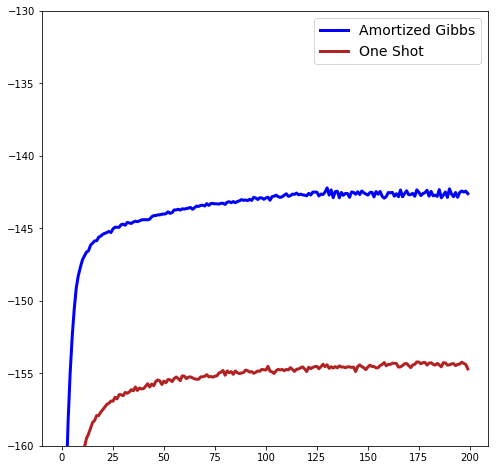

In [139]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(ELBO_ag_a, c='blue', linewidth=3, label='Amortized Gibbs')
ax1.plot(ELBO_ave2_a, c='firebrick', linewidth=3, label='One Shot')
ax1.legend(fontsize=14)
ax1.set_ylim([-160, -130])
plt.savefig('ELBOs_gmm.svg')

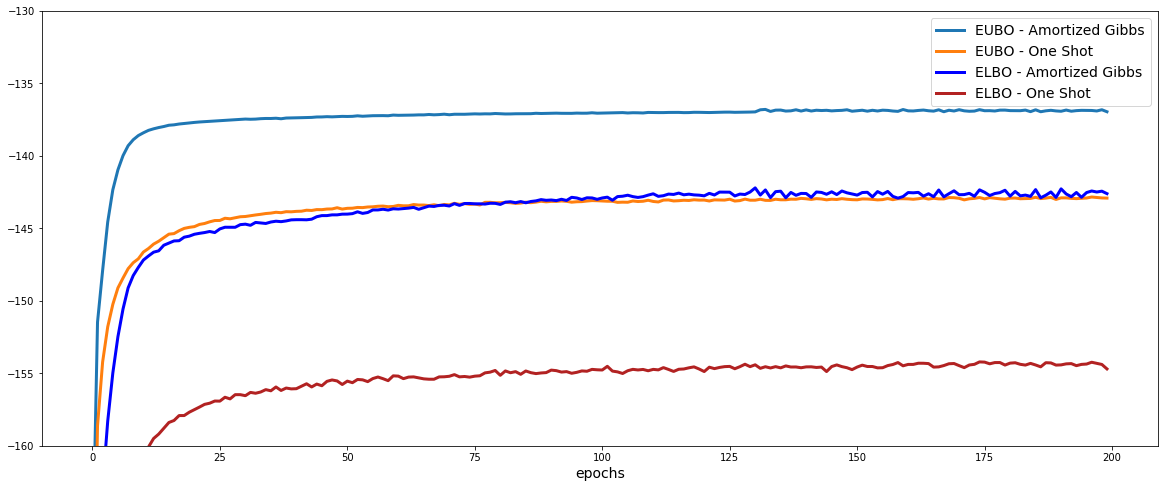

In [142]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(EUBO_ag_a, linewidth=3, label='EUBO - Amortized Gibbs')
ax1.plot(EUBO_ave2_a,linewidth=3, label='EUBO - One Shot')

ax1.set_ylim([-160, -130])
ax1.plot(ELBO_ag_a, c='blue', linewidth=3, label='ELBO - Amortized Gibbs')
ax1.plot(ELBO_ave2_a, c='firebrick', linewidth=3, label='ELBO - One Shot')
ax1.legend(fontsize=14)
ax1.set_xlabel('epochs', fontsize=14)

plt.savefig('EUBOs_ELBOs_gmm.svg')

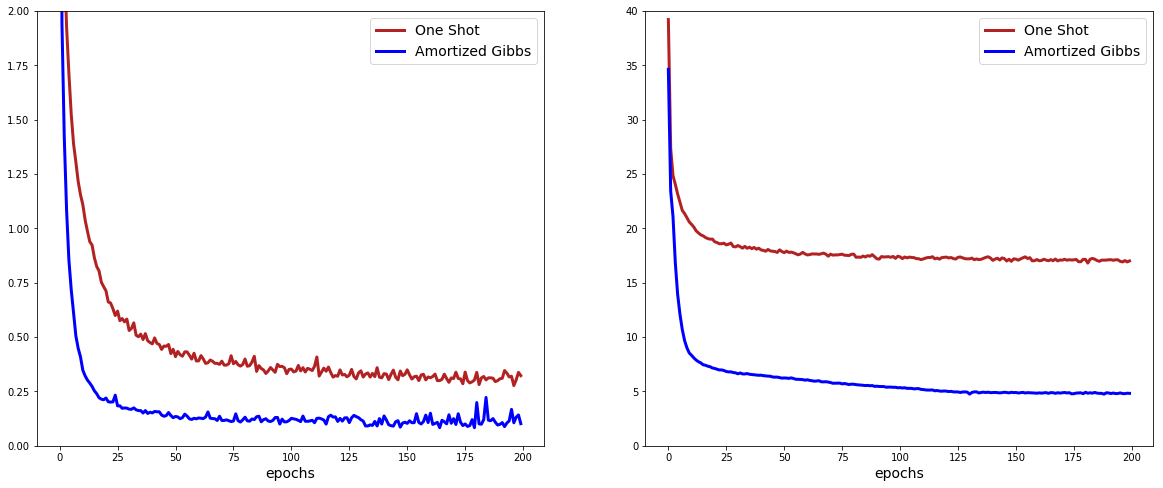

In [137]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax1.plot((KL_z_ex_os2_a + KL_z_in_os2_a) / 2., c='firebrick', linewidth=3, label='One Shot')
ax1.plot((KL_z_in_ag_a+KL_z_ex_ag_a) / 2., c='blue', linewidth=3, label='Amortized Gibbs')
ax1.legend(fontsize=14)
ax1.set_ylim([0, 2])

ax2 = fig.add_subplot(1,2,2)
ax2.plot((KL_eta_ex_os2_a + KL_eta_in_os2_a) / 2., c='firebrick', linewidth=3, label='One Shot')
ax2.plot(aa, c='blue', linewidth=3, label='Amortized Gibbs')
ax2.legend(fontsize=14)
ax2.set_ylim([0, 40])
ax1.set_xlabel('epochs', fontsize=14)
ax2.set_xlabel('epochs', fontsize=14)
plt.savefig('KLs_gmm.svg')

In [9]:
def save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in):
    fout = open('results/logs-' + PATH +'.txt', 'w+')
    fout.write('EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) 
                   + str(KLs_eta_ex[i]) + str(KLs_eta_in[i]) + str(KLs_z_ex[i]) + str(KLs_z_in[i]) + '\n')
    fout.close()
save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in)

NameError: name 'EUBOs' is not defined

In [10]:
# PATH = 'ag-correct-stage2-50000datasets-oneshot-%dsteps' % STEPS
# opt2 =  torch.optim.Adam(list(enc_init.parameters()) + list(enc_global.parameters()) + list(enc_local.parameters()),lr=1e-5, betas=(0.9, 0.99))

In [11]:
flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO_ave, ELBO_ave, ESS, EUBO_os, ELBO_os, EUBO_ag, ELBO_ag, KLs_eta_ex_os, KLs_eta_in_os, KL_z_ex_os, KL_z_in_os, KLs_eta_ex_ag, KLs_eta_in_ag, KL_z_ex_ag, KL_z_in_ag\n')
flog.close()

num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    EUBO_os = 0.0
    ELBO_os = 0.0
    EUBO_ag = 0.0
    ELBO_ag = 0.0
    
    ESS = 0.0
    KL_eta_ex_ag = 0.0
    KL_eta_in_ag = 0.0
    KL_z_ex_ag = 0.0
    KL_z_in_ag = 0.0
    
    KL_eta_ex_os = 0.0
    KL_eta_in_os = 0.0
    KL_z_ex_os = 0.0
    KL_z_in_os = 0.0
    
    for step in range(num_batches):
        opt2.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
#         batch_Zs = Zs_true[batch_indices]
#         batch_mus = mus_true[batch_indices]
#         batch_sigma2 = sigma2_true[batch_indices]
        batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, eubo_os, elbo_os, eubo_ag, elbo_ag, kl_eta_ex_os, kl_eta_in_os, kl_z_ex_os, kl_z_in_os, kl_eta_ex_ag, kl_eta_in_ag, kl_z_ex_ag, kl_z_in_ag = ag(batch_Xs, Pi, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)
        eubo.backward()
        opt2.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        
        EUBO_os += eubo_os.item()
        ELBO_os += elbo_os.item()
        EUBO_ag += eubo_ag.item()
        ELBO_ag += elbo_ag.item()
        
        ESS += ess.item()
        KL_eta_ex_ag += kl_eta_ex_ag.item()
        KL_eta_in_ag += kl_eta_in_ag.item()
        KL_z_ex_ag += kl_z_ex_ag.item()
        KL_z_in_ag += kl_z_in_ag.item()
        
        KL_eta_ex_os += kl_eta_ex_os.item()
        KL_eta_in_os += kl_eta_in_os.item()
        KL_z_ex_os += kl_z_ex_os.item()
        KL_z_in_os += kl_z_in_os.item()
        flog = open('results/log-' + PATH + '.txt', 'a+')
        flog.write(str(eubo.item()) + ', ' + str(elbo.item()) + ', ' + str(ess.item()) + ', ' + 
               str(eubo_os.item()) + ', ' + str(elbo_os.item()) + ', ' + str(eubo_ag.item()) + ', ' + str(elbo_ag.item()) + ', ' +
               str(kl_eta_ex_os.item()) + ', ' + str(kl_eta_in_os.item()) + ', ' + str(kl_z_ex_os.item()) + ', ' + str(kl_z_in_os.item()) + ', ' +
               str(kl_eta_ex_ag.item()) + ', ' + str(kl_eta_in_ag.item()) + ', ' + str(kl_z_ex_ag.item()) + ', ' + str(kl_z_in_ag.item()) + '\n')
        flog.close()
             
    EUBO /= num_batches
    ELBO /= num_batches
    
    EUBO_os /= num_batches
    ELBO_os /= num_batches
    EUBO_ag /= num_batches
    ELBO_ag /= num_batches
    
    ESS /= num_batches
    KL_eta_ex_ag /= num_batches
    KL_eta_in_ag /= num_batches
    KL_z_ex_ag /= num_batches
    KL_z_in_ag /= num_batches
    
    KL_eta_ex_os /= num_batches
    KL_eta_in_os /= num_batches
    KL_z_ex_os /= num_batches
    KL_z_in_os /= num_batches 

    time_end = time.time()  
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
            % (epoch, EUBO, ELBO, ESS,  KL_eta_ex_ag, KL_eta_in_ag, KL_z_ex_ag, KL_z_in_ag, time_end - time_start))


epoch=0, EUBO=-137.702, ELBO=-143.959, ESS=2.807, EX_eta=5.903, IN_eta=2.996, EX_z=0.175, IN_z=0.055 (405s)
epoch=1, EUBO=-137.699, ELBO=-143.951, ESS=2.832, EX_eta=5.858, IN_eta=2.963, EX_z=0.139, IN_z=0.052 (405s)
epoch=2, EUBO=-137.699, ELBO=-143.982, ESS=2.844, EX_eta=6.015, IN_eta=2.967, EX_z=0.119, IN_z=0.052 (405s)
epoch=3, EUBO=-137.701, ELBO=-143.940, ESS=2.847, EX_eta=5.814, IN_eta=2.944, EX_z=0.137, IN_z=0.052 (405s)
epoch=4, EUBO=-137.691, ELBO=-143.954, ESS=2.850, EX_eta=5.903, IN_eta=2.953, EX_z=0.157, IN_z=0.051 (406s)
epoch=5, EUBO=-137.685, ELBO=-143.955, ESS=2.851, EX_eta=5.835, IN_eta=2.952, EX_z=0.148, IN_z=0.051 (406s)
epoch=6, EUBO=-137.695, ELBO=-143.948, ESS=2.858, EX_eta=5.930, IN_eta=2.951, EX_z=0.154, IN_z=0.052 (406s)
epoch=7, EUBO=-137.694, ELBO=-143.903, ESS=2.861, EX_eta=5.834, IN_eta=2.952, EX_z=0.191, IN_z=0.051 (406s)
epoch=8, EUBO=-137.696, ELBO=-143.972, ESS=2.863, EX_eta=5.881, IN_eta=2.953, EX_z=0.144, IN_z=0.051 (406s)
epoch=9, EUBO=-137.691, ELBO

KeyboardInterrupt: 

In [ ]:
def plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, num_samples):
    fig = plt.figure(figsize=(20, 30))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax1.tick_params(labelsize=18)
    ax1.set_ylim([-220, -130])
    ax1.legend(fontsize=18)
    ##
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(KLs_eta_ex, '#66b3ff', label='KLs_eta_ex')
    ax2.plot(KLs_eta_in, '#ff9999', label='KLs_eta_in')
    ax2.plot(KLs_z_ex, '#99ff99', label='KLs_z_ex')
    ax2.plot(KLs_z_in, 'gold', label='KLs_z_in')   
    ax2.plot(np.ones(len(KLs_z_in)) * 5, 'k', label='const=5.0')
    ax2.legend(fontsize=18)
    ax2.tick_params(labelsize=18)
    ax2.set_ylim([-1, 30])
    ##
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel('epochs (%d gradient steps per epoch)'  % num_batches, size=18)
    ax3.legend()
    plt.savefig('results/train-' + PATH + '.svg')

In [ ]:
plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, NUM_SAMPLES)

In [ ]:
STEPS = 50
def reverse(X, z, mus_prev, precisions_prev, N, D, K, batch_size):
    data = torch.cat((X, z), dim=-1).view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc_global(data, K, D, 1, batch_size)  
    log_q_eta =  Normal(q_mean[0], q_sigma[0]).log_prob(mus_prev).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions_prev).sum(-1).sum(-1)## B
    return log_q_eta

def test(x, Pi, N, K, D, num_samples, steps, batch_size):
    log_increment_weights = torch.zeros((steps, num_samples, batch_size))
    log_p_joints = torch.zeros((steps, num_samples, batch_size))
    log_qf = torch.zeros((steps-1, num_samples, batch_size))
    log_qr = torch.zeros((steps-1, num_samples, batch_size))
    Z_samples = torch.zeros((num_samples, batch_size, N, K))
    mus_prevs = torch.zeros((num_samples, batch_size, K, D))
    precisions_prevs = torch.zeros((num_samples, batch_size, K, D))
    
    for m in range(steps):
        if m == 0:
            for l in range(num_samples):
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = Init_step(x, N, D, K, batch_size)
                mus_prevs[l] = mus
                precisions_prevs[l] = precisions
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                labels = z.nonzero()
                log_p_z = cat(Pi).log_prob(z).sum(-1)
                sigmas = 1. / torch.sqrt(precisions)
                log_p_x = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1)
                log_increment_weights[m, l] = log_p_x + log_p_z - log_q_z     
                log_p_joints[m, l] = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                
        else:
            for l in range(num_samples):
                z_prev = Z_samples[l]
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z_prev, N, D, K, batch_size)
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                log_p_joints[m, l] = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_qf[m-1, l] = log_q_eta + log_q_z
                
                mus_prev = mus_prevs[l]
                precisions_prev = precisions_prevs[l]
                
                log_qr[m-1, l] = reverse(x, z, mus_prev, precisions_prev, N, D, K, batch_size)
                log_p_joint = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_q_z - log_q_eta
                mus_prevs[l] = mus
                precisions_prevs[l] = precisions
    detail_balances = log_p_joints[1:] - log_p_joints[:-1] -log_qf + log_qr
    increment_weights = torch.exp(log_increment_weights - logsumexp(log_increment_weights, 1).unsqueeze(1).repeat(1, num_samples, 1)).detach()
    esses = (1./ (increment_weights ** 2).sum(1))                   
    log_last_weights = log_increment_weights[-1] ## S * B
    ## EUBO and ELBO
    eubos = torch.mul(increment_weights, log_increment_weights).sum(1).mean(-1)
    elbos = log_increment_weights.mean(1).mean(-1)     
    return eubos, elbos, esses, log_increment_weights, detail_balances

In [ ]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Xs = shuffler(batch_Xs, N, K, D, batch_size)
    return batch_Xs
batch_Xs = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
eubo, elbo, ess, log_increment_weights, detail_balances = test(batch_Xs, Pi, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)

In [ ]:

detail_balances.shape

In [ ]:
for i in range(BATCH_SIZE):
    log_weights = log_increment_weights[:, :, i]
    ess_stepwise = ess[:, i].data.numpy()
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    weights = torch.exp(log_weights - logsumexp(log_weights, -1)[:, None]).data.numpy()
    db = detail_balances[:, :, i].mean(-1)
    ax1.plot(db.data.numpy(), 'r-o')
    ax1.set_ylim([-20, 20])
    for s in range(NUM_SAMPLES):
        ax2.plot(ess_stepwise, 'b-o')
        ax3.plot(weights[:, s], 'g-o')
        ax2.set_ylim([1.0, 7])


In [ ]:
ess

In [ ]:


def test(x, num_seqs, Pi, N, K, D, steps, batch_size):
    LLs = [] 
    for m in range(steps):
        if m == 0:
            mus, precisions, log_p_eta = inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
        else:
            q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z, N, D, K, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
            labels = z.nonzero()
            sigmas = 1. / torch.sqrt(precisions)
            ll = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1).mean()
            LLs.append(ll.item())
    E_precisions = q_alpha / q_beta
    E_mus = q_mean
    E_z = torch.argmax(zs_pi, dim=-1)

    return z, mus, precisions, LLs, E_mus, E_precisions, E_z

x,z_true = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
z, mus, precisions, LLs, E_mus, E_precisions, E_z = test(x, num_seqs, Pi, N, K, D, STEPS, BATCH_SIZE)

In [ ]:
def plot_final_samples(Xs, Zs, mus, precisions, steps, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,100))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = z
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

In [ ]:
plot_final_samples(x, E_z, E_mus, E_precisions, STEPS, BATCH_SIZE)

In [ ]:
plt.plot(LLs[:20])

In [ ]:
plt.plot(LLs)

In [ ]:
plt.plot(LLs[:10])

In [ ]:
np.array(LLs).mean()

In [ ]:
np.exp(-3)